In [99]:
import time
import os
import plotly.express          as     px
import plotly.graph_objects    as     go
import matplotlib.pyplot       as     plt
import pandas                  as     pd
import numpy                   as     np
import seaborn                 as     sns
#from surprise                  import SVDpp
#from surprise                  import Dataset, Reader
#from surprise.model_selection  import train_test_split
#from surprise                  import accuracy
import tensorflow              as tf
from tensorflow                import keras
from collections               import defaultdict
from scipy.linalg              import svd
from datetime                  import datetime
from sklearn.preprocessing     import MinMaxScaler
from matplotlib                import pyplot

In [100]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN
    #agg.dropna(inplace=True)
    data = np.array(agg)
    data1 = data[~np.isnan(data).any(axis=1)]
    return data1

def parser(s):
    return datetime.strptime(s, '%d/%m/%Y')

def AddNewValue(x_test, NewValue):
    x_test_copy = np.copy(x_test)
    for i in range(x_test.shape[1]-1):
        x_test[0][i][0] = x_test_copy[0][i+1][0]
        x_test[0][x_test.shape[1]-1][0]=NewValue
        
    return x_test

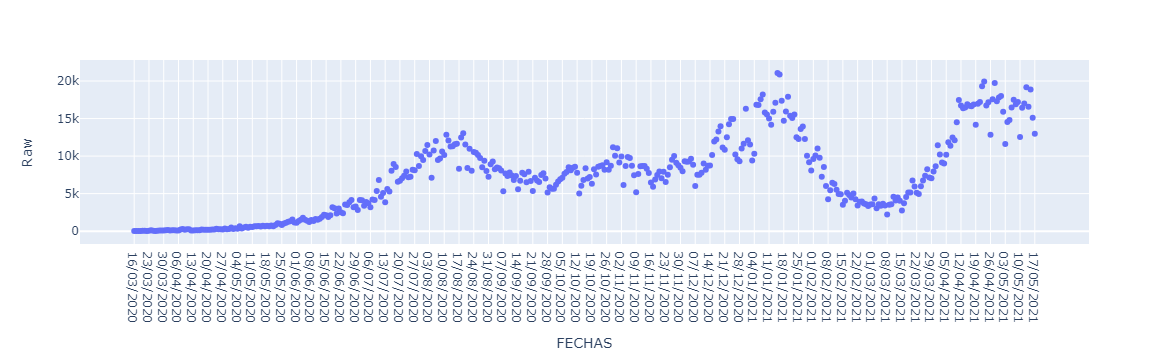

COVID
       Raw  Normalized      FECHAS
0       12    0.000095  16/03/2020
1       18    0.000380  17/03/2020
2       27    0.000807  18/03/2020
3       26    0.000759  19/03/2020
4       47    0.001756  20/03/2020
..     ...         ...         ...
423  19160    0.908961  13/05/2021
424  16581    0.786548  14/05/2021
425  18873    0.895339  15/05/2021
426  15093    0.715920  16/05/2021
427  12984    0.615815  17/05/2021

[428 rows x 3 columns]


In [101]:
path = os.path.join('c:' + os.sep, 'Users', 'chris', 'OneDrive', 'Software', '18 mayo', 'Casos_Diarios_COL2.csv')

df = pd.read_csv(path)
        
time_series = pd.Series(df['DIA'].values)
fechas      = pd.Series(df['FECHA'].values)

Y_all      = time_series.to_numpy()
Y_raw      = [i for i in range(len(Y_all))]

COVID_Time_Series_df = pd.DataFrame(time_series.values,columns=['Raw'])

time_Series = np.array(time_series).reshape(-1,1)

sc = MinMaxScaler(feature_range=(0, 1))
serie_scaled = sc.fit_transform(time_Series)
#SReal_Norm  = Scaler_Real.transform(time_Series)
time_series_covid = pd.DataFrame(data=serie_scaled)

COVID_Time_Series_df['Normalized'] = pd.DataFrame(time_series_covid.values)
COVID_Time_Series_df['FECHAS'] = pd.DataFrame(fechas.values)
Fechas           = COVID_Time_Series_df['FECHAS']
Serie            = COVID_Time_Series_df['Normalized']

fig = px.scatter(COVID_Time_Series_df, x='FECHAS',y='Raw')
              
fig.show()

print('COVID')
print(COVID_Time_Series_df)  

In [102]:
#Medidas de error

def MAPE(Real, Est):
    Dif = np.zeros(int(len(Real)))
    for a in range(int(len(Real))):
        Dif[a] = (abs(Real[a] - Est[a])/abs(Real[a]))*100
    Mape = np.mean(Dif)    
    print(Mape)
    return Mape, Dif

def RMSE(Real, Est):
    Dif   = np.zeros(int(len(Real)))
    for a in range(int(len(Real))):
        Dif[a] = ((Est[a] - Real[a])**2)
    mse  = np.mean(Dif)
    rmse = np.sqrt(mse)    
    return rmse, mse

def mda(Real: np.ndarray, Pronos: np.ndarray):
    DifRe  = np.zeros(int(len(Real))-1)
    DifPro = np.zeros(int(len(Real))-1)
    Vmda = np.zeros(int(len(Real))-1)
    for a in range(int(len(Real))-1):
        DifRe[a] = Real[a] - Real[a+1]
        DifPro[a] = Pronos[a] - Pronos[a+1]
        Vmda[a] = (np.sign(DifRe[a]) == np.sign(DifPro[a]))
    mda = np.mean(Vmda)*100
    print(mda)
    return mda

def RMSEDD(Real: np.ndarray, Pronos: np.ndarray):
    DifRe  = np.zeros(int(len(Real))-1)
    DifPro = np.zeros(int(len(Real))-1)
    mse    = np.zeros(int(len(Real))-1)
    for a in range(int(len(Real))-1):
        DifRe[a]  = Real[a] - Real[a+1]
        DifPro[a] = Pronos[a] - Pronos[a+1]
        mse[a]    = (DifRe[a] - DifPro[a])**2

    MSEDD  = np.mean(mse)
    RMSEDD = np.sqrt(MSEDD)

    return RMSEDD, MSEDD

def Variance(actual: np.ndarray, predicted: np.ndarray):
    Dif    = np.mean(actual-predicted)
    DifVar = actual - predicted
    Var2   = np.mean(DifVar*DifVar)
    Var    = np.sqrt(Var2)
    print('Std Dev')
    print(Var)
    print('mean Diference')
    print(Dif)
    return Dif, Var

In [103]:
### Función para buscar la mejor L y la mejor r.
def Forecast_SVD(Fechas, Serie, N, L, n, r, HP):
    
    dfSerie     = pd.DataFrame(Serie[:N])
    #H10 = series_to_supervised(data=dfSerie.values.astype('float32').reshape(-1,1), n_in=L-1, n_out=1)
    H10 = series_to_supervised(data=dfSerie.values.reshape(-1,1), n_in=L-1, n_out=1)
    MH10      = np.array(H10)
    #print('H Completa')
    #print(MH10.shape)
    MH10_test = MH10[n-L+1:,:]
    #print('Forma de H de prueba')
    #print(MH10_test.shape)
    MH10_train = MH10[:n-L+1,:]
    #print('Forma de H de entrenamiento')
    #print(MH10.shape)
    
    ### Entrenamiento
    btrain    = MH10_train[:,-1]
    Htrain    = MH10_train[:,:-1]
    U, s, VT  = np.linalg.svd(Htrain,full_matrices=0)
    SigmaH10  = np.zeros((Htrain.shape[0], Htrain.shape[1]))
    SigmaH10[:Htrain.shape[1], :Htrain.shape[1]] = np.diag(s)
    #print('Forma de Sigma completa')
    #print(SigmaH10.shape)

    NSigmaH10 = SigmaH10[:, :r]
    #print('Nuevo Sigma con r valores singulares')
    #print(NSigmaH10.shape)
    NVT       = VT[:r, :]
    #print('Nuevo V de r elementos')
    #print(NVT.shape)
    NV        = NVT.T
    rs        = s[:r]
    InvNSigmaH10 = np.linalg.inv(np.diag(rs))
    UT        = U.T
    NUT       = UT[:r,:]
    NVIS      = NV @ InvNSigmaH10
    NVISNUT   = NVIS @ NUT
    Nxhat     = NVISNUT @ btrain
    #print('aproximación de x con r valores singulares')
    #print(Nxhat.shape)
    #print(Nxhat)
    fcast_train = Htrain @ Nxhat

    fcast_train = np.array(fcast_train).reshape(-1,1)
    bbtrain = np.array(btrain).reshape(-1,1)

    ###Rescaling
    Fcast_train = sc.inverse_transform(fcast_train)
    Btrain      = sc.inverse_transform(bbtrain)
    
    #print('Mape de entrenamiento')
    MapeB10train, DifB10train = MAPE(Btrain, Fcast_train)
    #print('MDA de entrenamiento')
    MdaB10train = mda(Btrain, Fcast_train)
    #print(MdaB10train)
    #print('Desviación Estándar de entrenamiento')
    rmseddB10train, mseddB10train = RMSEDD(Btrain, Fcast_train)  
    #print('RMES de entrenamiento')
    RMSEB10train, MSEB10train = RMSE(Btrain, Fcast_train)
    #print(RMSEB10train)
    MTrain = np.array([[MapeB10train],[MdaB10train],[rmseddB10train],[RMSEB10train]])

   
    #MH10_test  = np.array(H10_test)
    btest      = MH10_test[:,-1]
    Htest      = MH10_test[:,:-1]
    fcast_test = Htest @ Nxhat
    #print('Tamaño del Pronóstico de b de Prueba')
    #print(Fcast_test.shape)
    
    ###Rescaling
    fcast_test = np.array(fcast_test).reshape(-1,1)
    bbtest     = np.array(btest).reshape(-1,1)
    Btest      = sc.inverse_transform(bbtest)
    Fcast_test = sc.inverse_transform(fcast_test)
    
    #print('Mape de Prueba')
    MapeB10test, DifB10test = MAPE(Btest, Fcast_test)
    #print('MDA de Prueba')
    MdaB10test = mda(Btest, Fcast_test)
    #print(MdaB10test)
    #print('Desviación Estándar de Prueba')
    rmseddB10test, mseddB10test = RMSEDD(Btest, Fcast_test)  
    #print('RMES de Prueba')
    RMSEB10test, MSEB10test = RMSE(Btest, Fcast_test)
    #print(RMSEB10test)
    
    MTest = np.array([[MapeB10test],[MdaB10test],[rmseddB10test],[RMSEB10test]])
    
    ### Pronóstico Recursivo
    ##  Unimos Htrain y Htest, a la vez también btrain y btest
    Hfull                      = np.concatenate((Htrain,Htest),axis=0) #Uniendo train y test
    bfull                      = np.concatenate((btrain,btest),axis=0) #Uniendo train y test 
    U, s, VT                   = np.linalg.svd(Hfull,full_matrices=0)
    SigmaH10                   = np.zeros((Hfull.shape[0], Hfull.shape[1]))
    SigmaH10[:Hfull.shape[1], :Hfull.shape[1]] = np.diag(s)
    NSigmaH10                  = SigmaH10[:, :r]
    NVT                        = VT[:r, :]
    NV                         = NVT.T
    rs                         = s[:r]
    InvNSigmaH10               = np.linalg.inv(np.diag(rs))
    UT                         = U.T
    NUT                        = UT[:r,:]
    NVIS                       = NV @ InvNSigmaH10
    NVISNUT                    = NVIS @ NUT
    Nxhat                      = NVISNUT @ bfull
    ##  Termina. Unimos Htrain y Htest, a la vez también btrain y btest
    Hfcast_0                      = Htest                  #creamos H de pronóstico inicial al copiar Htest   
    Hfcast_0[:,:Htest.shape[1]-1] = Hfcast_0[:,1:Htest.shape[1]]
    Hfcast_0[:,Htest.shape[1]-1]  = btest                  #le agregamos en la última columna btest                              
    Hfcast = Hfcast_0
    fcast = []

    for i in range(HP):          #repetir según el tamaño del horizonte de pronóstico
        VFcast = Hfcast @ Nxhat
        fcast.append(VFcast[-1]) #guardamos el último valor que es el pronóstico
        Hfcast[:,:Htest.shape[1]-1] = Hfcast[:,1:Htest.shape[1]] #copiamos la Hfcast anterior menos la 1er columna
        Hfcast[:,Htest.shape[1]-1]  = VFcast # en la última columna colocamos el nuevo vector VFcast
        
    nfcast = np.array(fcast)
    #print(NFcast.shape) 
    #print(NFcast)         
      
    Real_df = pd.DataFrame(Serie[N:N+HP])
    Real    = np.array(Real_df)
    ##Rescaling
    nfcast = np.array(nfcast).reshape(-1,1)
    NFcast = sc.inverse_transform(nfcast)

    #print('MAPE del Pronóstico')
    MapeF, DifF = MAPE(Real, NFcast)
    #print('MDA del Pronóstico')
    Fcast_nd = NFcast.reshape(-1)
    MdaF = mda(Real, Fcast_nd)
    #print(MdaF)
    #print('Desviación Estándar del Pronóstico')
    rmseddF, mseddF = RMSEDD(Real, NFcast)  
    #print('RMSE del Pronóstico')
    rmseF, mseF = RMSE(Real, NFcast)
    #print(rmseF,mseF)
    
    MFcast = np.array([[MapeF],[MdaF],[rmseddF],[rmseF]])  
    
    return Fcast_train, Fcast_test, Fcast_nd, MTrain, MTest, MFcast

In [104]:
### Función para pronósticar con r valores singulares.
def Forecast_SVD_Final(Fechas, Serie, N, L, n, r, HP):
    
    dfSerie    = pd.DataFrame(Serie[:N])
    H10        = series_to_supervised(data=dfSerie.values.astype('float32').reshape(-1,1), n_in=L-1, n_out=1)
    MH10       = np.array(H10)
    #print('H Completa')
    #print(MH10.shape)
    MH10_test  = MH10[n-L+1:,:]
    #print('Forma de H de prueba')
    #print(MH10_test.shape)
    MH10_train = MH10[:n-L+1,:]
    #print('Forma de H de entrenamiento')
    #print(MH10.shape)
    
    ### Entrenamiento
    btrain    = MH10_train[:,-1]
    Htrain    = MH10_train[:,:-1]
    U, s, VT  = np.linalg.svd(Htrain,full_matrices=0)
    SigmaH10  = np.zeros((Htrain.shape[0], Htrain.shape[1]))
    SigmaH10[:Htrain.shape[1], :Htrain.shape[1]] = np.diag(s)
    #print('Forma de Sigma completa')
    #print(SigmaH10.shape)

    NSigmaH10 = SigmaH10[:, :r]
    #print('Nuevo Sigma con r valores singulares')
    #print(NSigmaH10.shape)
    NVT = VT[:r, :]
    #print('Nuevo V de r elementos')
    #print(NVT.shape)
    NV = NVT.T
    rs = s[:r]
    InvNSigmaH10 = np.linalg.inv(np.diag(rs))
    UT = U.T
    NUT = UT[:r,:]
    NVIS = NV @ InvNSigmaH10
    NVISNUT = NVIS @ NUT
    Nxhat        = NVISNUT @ btrain
    #print('aproximación de x con r valores singulares')
    #print(Nxhat.shape)
    #print(Nxhat)    
    fcast_train = Htrain @ Nxhat
    
    ###Rescaling
    fcast_train = np.array(fcast_train).reshape(-1,1)
    bbtrain     = np.array(btrain).reshape(-1,1)
    Fcast_train = sc.inverse_transform(fcast_train)
    Btrain      = sc.inverse_transform(bbtrain)
    
    print('Mape de Entrenamiento')
    MapeB10train, DifB10train = MAPE(Btrain, Fcast_train)
    print('MDA de Entrenamiento')
    MdaB10train               = mda(Btrain, Fcast_train)
    print('RMSE de Entrenamiento')
    RMSEB10train, MSEB10train = RMSE(Btrain, Fcast_train)
    print(RMSEB10train)
    print('Desviación de la Dirección de Entrenamiento en RMSE')
    rmseddB10train, mseddB10train = RMSEDD(Btrain, Fcast_train)  
    print(rmseddB10train)
    
    MTrain = np.array([[MapeB10train],[MdaB10train],[rmseddB10train],[RMSEB10train]])

    FechasbTrain_df = pd.DataFrame(Fechas[MH10.shape[1]:(MH10.shape[1]+MH10.shape[0])])
    Fcast_Norm_df                   = pd.DataFrame(Btrain, columns=['btrain'])
    Fcast_Norm_df['FechasBTrain']   = pd.DataFrame(FechasbTrain_df.values)
    Fcast_Norm_df['FcastBtrain']    = pd.DataFrame(Fcast_train)

    fig = go.Figure()
    # Add traces
    fig.add_trace(go.Scatter(x=Fcast_Norm_df['FechasBTrain'], y=Fcast_Norm_df['btrain'],
                        mode='lines', name='Entrenamiento'))
    fig.add_trace(go.Scatter(x=Fcast_Norm_df['FechasBTrain'], y=Fcast_Norm_df['FcastBtrain'],
                        mode='lines+markers', name='Pronóstico de Entrenamiento'))

    btest      = MH10_test[:,-1]
    Htest      = MH10_test[:,:-1]
    fcast_test = Htest @ Nxhat
    ###Rescaling
    fcast_test = np.array(fcast_test).reshape(-1,1)
    bbtest     = np.array(btest).reshape(-1,1)
    Fcast_test = sc.inverse_transform(fcast_test)
    Btest      = sc.inverse_transform(bbtest)
    #print('Tamaño del Pronóstico de b de Prueba')
    #print(Fcast_test.shape)
    print('Mape de Validación')
    MapeB10test, DifB10test = MAPE(Btest, Fcast_test)
    print('MDA de Validación')
    MdaB10test = mda(Btest, Fcast_test)
    print('RMES de Validación')
    RMSEB10test, MSEB10test = RMSE(Btest, Fcast_test)
    print(RMSEB10test)
    print('Desviación de la Dirección de Validación en RMSE')
    rmseddB10test, mseddB10test = RMSEDD(Btest, Fcast_test)  
    print(rmseddB10test)
    
    MTest = np.array([[MapeB10test],[MdaB10test],[rmseddB10test],[RMSEB10test]])
    
    #FechasbTest_df  = pd.DataFrame(Fechas[MH10.shape[1]+MH10.shape[0]-1:MH10.shape[1]+MH10.shape[0]+MH10_test.shape[0]+MH10_test.shape[1]-2])
    FechasbTest_df  = pd.DataFrame(Fechas[n+1:N])
    Fcast_Norm_df                   = pd.DataFrame(Btest, columns=['btest'])
    Fcast_Norm_df['FechasBTest']    = pd.DataFrame(FechasbTest_df.values)
    Fcast_Norm_df['FcastBtest']     = pd.DataFrame(Fcast_test)

    # Add traces
    fig.add_trace(go.Scatter(x=Fcast_Norm_df['FechasBTest'], y=Fcast_Norm_df['btest'],
                        mode='lines', name='Validación'))
    fig.add_trace(go.Scatter(x=Fcast_Norm_df['FechasBTest'], y=Fcast_Norm_df['FcastBtest'],
                        mode='lines+markers', name='Pronóstico de Validación'))

    ### Pronóstico Recursivo
    ##  Unimos Htrain y Htest, a la vez también btrain y btest
    Hfull                      = np.concatenate((Htrain,Htest),axis=0) #Uniendo train y test
    bfull                      = np.concatenate((btrain,btest),axis=0) #Uniendo train y test 
    U, s, VT                   = np.linalg.svd(Hfull,full_matrices=0)
    SigmaH10                   = np.zeros((Hfull.shape[0], Hfull.shape[1]))
    SigmaH10[:Hfull.shape[1], :Hfull.shape[1]] = np.diag(s)
    NSigmaH10                  = SigmaH10[:, :r]
    NVT                        = VT[:r, :]
    NV                         = NVT.T
    rs                         = s[:r]
    InvNSigmaH10               = np.linalg.inv(np.diag(rs))
    UT                         = U.T
    NUT                        = UT[:r,:]
    NVIS                       = NV @ InvNSigmaH10
    NVISNUT                    = NVIS @ NUT
    Nxhat                      = NVISNUT @ bfull
    ##  Termina. Unimos Htrain y Htest, a la vez también btrain y btest
    Hfcast_0                      = Htest                  #solo utilizando xhat de train   
    Hfcast_0[:,:Htest.shape[1]-1] = Hfcast_0[:,1:Htest.shape[1]]
    Hfcast_0[:,Htest.shape[1]-1]  = btest                  #solo utilizando xhat de train                               #Uniendo train y test                              
    Hfcast = Hfcast_0
    fcast = []

    for i in range(HP):  
        VFcast = Hfcast @ Nxhat
        fcast.append(VFcast[-1])
        Hfcast[:,:Htest.shape[1]-1] = Hfcast[:,1:Htest.shape[1]]
        Hfcast[:,Htest.shape[1]-1]  = VFcast
        
    nfcast  = np.array(fcast)       
    Real_df = pd.DataFrame(Serie[N:N+HP])
    real    = np.array(Real_df).reshape(-1,1)
    Real    = sc.inverse_transform(real)
    #Real    = np.array(Real_df)
    
    nfcast  = np.array(nfcast).reshape(-1,1)
    Fcast   = sc.inverse_transform(nfcast)

    print('MAPE del Pronóstico')
    MapeF, DifF = MAPE(Real, Fcast)
    print('MDA del Pronóstico')
    Fcast_nd = Fcast.reshape(-1)
    MdaF     = mda(Real, Fcast_nd)
    print('RMSE del Pronóstico')
    rmseF, mseF = RMSE(Real, Fcast)
    print(rmseF,mseF)
    print('Desviación de la Dirección del Pronóstico en RMSE')
    rmseddF,mseddF = RMSEDD(Real, Fcast)  
    print(rmseddF)
    
    
    MFcast = np.array([[MapeF],[MdaF],[rmseddF],[rmseF]])

    FechasF_df                   = pd.DataFrame(Fechas[N:N+HP])
    Fcast_F_df                   = pd.DataFrame(Real, columns=['Real'])
    Fcast_F_df['Fechas_Fcast']   = pd.DataFrame(FechasF_df.values)
    Fcast_F_df['Fcast']          = pd.DataFrame(Fcast)

    fig.add_trace(go.Scatter(x=Fcast_F_df['Fechas_Fcast'], y=Fcast_F_df['Real'],
                        mode='lines', name='Real'))
    fig.add_trace(go.Scatter(x=Fcast_F_df['Fechas_Fcast'], y=Fcast_F_df['Fcast'],
                        mode='lines+markers', name='Pronóstico'))
    
    # Actualizar el diseño para ajustar el tamaño
    fig.update_layout(
        width=1200,  # Establece el ancho de la gráfica en píxeles
        height=600,  # Establece la altura de la gráfica en píxeles
        title='Gráfica de Casos de COVID-19',  # Puedes personalizar el título según tu necesidad
        xaxis_title='Fechas',  # Etiqueta del eje X
        yaxis_title='Casos',  # Etiqueta del eje Y
    )
    
    fig.show()    
    
    return Fcast_train, Fcast_test, Fcast_nd, MTrain, MTest, MFcast

In [105]:
#HP = 21
#N  = 153      # Cota superior de los datos en la serie de tiempo
#n  = 111      # Cota superior del entrenamiento

#Onset
#HP = 21
#N  = 174      # Cota superior de los datos en la serie de tiempo
#n  = 132      # Cota superior del entrenamiento

#peak
HP = 21
N  = 292      # Cota superior de los datos en la serie de tiempo
n  = 250      # Cota superior del entrenamiento

#One Year Ago
#HP = 21
#N  = 407      # Cota superior de los datos en la serie de tiempo
#n  = 365      # Cota superior del entrenamiento

#One Year Ago BRA
#HP = 21
#N  = 392      # Cota superior de los datos en la serie de tiempo
#n  = 350      # Cota superior del entrenamiento


Drop = []

maxL = int(n/2)
L = np.arange(2, maxL, 1, dtype=int)
print(L)

for l in L:
    r = l
    print('L=')
    print(l)
    FTrain, FTest, Fcast, MTrain, MTest, MFcast = Forecast_SVD(Fechas, Serie, N, l, n, r, HP)
    Drop = np.append(Drop,MTest)
    #Drop = np.append(Drop,MFcast)
    
PerformanceL = np.array(Drop).reshape(-1,4)  
print(PerformanceL)    
#pos_bestL = np.where(PerformanceL == np.amin(PerformanceL[:,0])) #Según MAPE
#pos_bestL = np.where(PerformanceL == np.amin(PerformanceL[:,1])) #Según MDA
#pos_bestL = np.where(PerformanceL == np.amin(PerformanceL[:,2])) #Según RMSEDD
pos_bestL = np.where(PerformanceL == np.amin(PerformanceL[:,3])) #Según RMSE

print(pos_bestL)
L = np.array(int(pos_bestL[0]))+1   # Para 0,2,3
print(L)

Drop = []

r = np.arange(1, L, 1, dtype=int)
print(r)

for rr in r:
    print('r=')
    print(rr)
    FTrain, FTest, Fcast, MTrain, MTest, MFcast = Forecast_SVD(Fechas, Serie, N, L, n, rr, HP)
    Drop = np.append(Drop,MTest)
    #Drop = np.append(Drop,MFcast)
    
Performancer = np.array(Drop).reshape(-1,4)  
print(Performancer)    
#pos_bestr = np.where(Performancer == np.amin(Performancer[:,0])) #Según MAPE
#pos_bestr = np.where(Performancer == np.amin(Performancer[:,1])) #Según MDA
#pos_bestr = np.where(Performancer == np.amin(Performancer[:,2])) #Según RMSEDD
pos_bestr = np.where(Performancer == np.amin(Performancer[:,3])) #Según RMSE

print(pos_bestr)
r = np.array(int(pos_bestr[0]))+1    # Para 0,2,3
print(r)

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124]
L=
2
20.024282104793585
38.306451612903224
11.595113159229836
60.97560975609756
1535099.7128181686
55.00000000000001
L=
3
19.755541961961736
38.05668016194332
12.223165321083002
63.41463414634146
1764942.5518862312
60.0
L=
4
18.997154581571706
36.58536585365854
12.5397533040312
58.536585365853654
1786839.8747447568
50.0
L=
5
18.346676948077718
37.95918367346939
12.17843228960837
53.65853658536586
1787458.2159449416
45.0
L=
6
18.05018164879267
37.704918032786885
11.76424859963838
56.0975609756097

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

41.25
10.916154395733184
60.97560975609756
1658626.6139564519
60.0
L=
11
17.16472808220545
41.84100418410041
10.86089674593562
58.536585365853654
1618612.336562154
65.0
L=
12
15.15684303271951
42.436974789915965
11.19157909918324
58.536585365853654
1609317.3015995491
60.0
L=
13
15.012775159355924
42.19409282700422
11.440535482512498
60.97560975609756
1625360.285039276
65.0
L=
14
14.848156800396861
45.33898305084746
10.923472446622643
70.73170731707317
1691364.9176798083
65.0
L=
15
14.802929635074399
44.680851063829785
11.014890449055795
70.73170731707317
1702291.9364434753
70.0
L=
16
14.732967125505517
44.871794871794876
10.802914811916608
73.17073170731707
1682845.0021032149
65.0
L=
17
14.677354233785882
44.20600858369099
10.87970739397414
73.17073170731707
1681271.8273114015
65.0
L=
18
14.62615217782015
47.41379310344828
11.206125949292982
68.29268292682927
1680079.0661335762
65.0
L=
19
14.67719886997361
47.18614718614719
11.814101216827401
70.73170731707317
1684645.0827262355
70.0
L

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:14: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

14.533408684074166
50.0
12.212051214769073
68.29268292682927
1649947.547689965
70.0
L=
23
14.313504624791792
48.89867841409692
12.18687026762701
68.29268292682927
1693536.6108850471
70.0
L=
24
14.189658654626244
49.557522123893804
11.905067886384595
70.73170731707317
1764139.7668309042
75.0
L=
25
13.99422368147417
48.888888888888886
11.899266042224841
73.17073170731707
1793810.395830997
75.0
L=
26
14.012664218952136
50.44642857142857
11.924265821808117
70.73170731707317
1791913.3461078717
75.0
L=
27
13.934311298518336
50.224215246636774
11.866265176922415
70.73170731707317
1820889.15541171
70.0
L=
28
13.92015700330797
50.0
11.944993118708293
70.73170731707317
1841831.773662119
75.0
L=
29
12.936325828049432
50.2262443438914
11.942954790435772
70.73170731707317
1841634.1201972459
75.0
L=
30
12.499536928241834
48.18181818181818
11.882608559775175
70.73170731707317
1847291.4706850683
75.0
L=
31
12.248718214707798
49.77168949771689
11.90820414069529
70.73170731707317
1851332.0141969007
75.0

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

12.270276091381222
50.45871559633027
12.244702920362029
60.97560975609756
1840424.4507466196
75.0
L=
33
12.149162070792729
50.69124423963134
12.446463613820253
63.41463414634146
1834671.2867198687
75.0
L=
34
12.122360079546725
48.61111111111111
12.69799503509149
65.85365853658537
1834322.121155583
75.0
L=
35
12.054184726509577
49.76744186046512
12.664751000986573
65.85365853658537
1834481.3158492204
75.0
L=
36
11.914174734330754
49.532710280373834
12.773622860170272
65.85365853658537
1834312.3077878966
75.0
L=
37
11.876680995799985
50.70422535211267
12.710585094323887
68.29268292682927
1827053.0895605516
75.0
L=
38
11.806480183787796
50.47169811320755
12.70084548271329
68.29268292682927
1818175.2109732337
75.0
L=
39
11.81209943794181
51.65876777251185
12.58536408626549
65.85365853658537
1804676.8833247323
75.0
L=
40
11.766069427893289
50.476190476190474
12.459126809365292
63.41463414634146


C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

1833502.5766622946
75.0
L=
41
11.718213495519846
51.196172248803826
12.55974995137731
65.85365853658537
1841355.2746343566
75.0
L=
42
11.73012808527291
51.442307692307686
12.483031928356157
63.41463414634146
1849405.1028060466
75.0
L=
43
11.640977020682936
50.72463768115942
12.444766246372678
68.29268292682927
1846735.468528761
75.0
L=
44
11.613531359501973
50.970873786407765
12.517233487578718
65.85365853658537
1844363.7623805453
75.0
L=
45
11.446783104351349
52.19512195121951
12.49634787075195
65.85365853658537
1841229.6369357237
75.0
L=
46
11.45883743592953
51.9607843137255
12.497057916764009
65.85365853658537
1838926.0626042972
75.0
L=
47
11.50832059147567
52.21674876847291
12.647078020857169
63.41463414634146
1837001.0803934697
75.0
L=
48
11.40772301741071
52.97029702970298
12.818139418731723
65.85365853658537
1838708.66489126
75.0
L=
49
11.128308885081822
52.23880597014925
12.370165969932064
63.41463414634146


C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a 

1852756.5839094918
75.0
L=
50
11.105372980565194
52.0
12.523507136614596
63.41463414634146
1854206.5291660475
75.0
L=
51
11.089683611027754
53.266331658291456
12.552475087366853
65.85365853658537
1853937.2710063139
75.0
L=
52
10.867936490482839
53.03030303030303
12.74605852260801
63.41463414634146
1853787.9572097193
75.0
L=
53
10.890975219888588
51.26903553299492
12.263278813523524
60.97560975609756
1813333.6727815683
75.0
L=
54
10.840437890214933
52.04081632653062
12.242445594676756
60.97560975609756
1822528.2328937426
75.0
L=
55
10.771634374703185
53.84615384615385
12.20386411330312
56.09756097560976
1818571.8937448668
75.0
L=
56
10.68051869560462
54.123711340206185
12.204159319189682
56.09756097560976
1815870.188387228
75.0
L=
57
10.616682597762177
55.95854922279793
12.059565451311702
58.536585365853654


C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a 

1798593.4310607505
75.0
L=
58
10.495118725844698
57.291666666666664
12.783285524250884
60.97560975609756
1808703.0755654534
75.0
L=
59
10.42757784633943
59.16230366492147
12.44905291380288
63.41463414634146
1749127.4778648454
75.0
L=
60
10.435618743784532
58.42105263157895
12.17842692083894
60.97560975609756
1743657.5639567268
75.0
L=
61
10.41663643286584
58.201058201058196
11.728621598093458
60.97560975609756
1731974.6383068962
75.0
L=
62
10.436106634134408
58.51063829787234
11.868155678661443
60.97560975609756
1744549.716383327
75.0
L=
63
10.393445926658563
57.75401069518716
11.813593016284234
60.97560975609756
1722615.7904857737
75.0
L=
64
10.373181227599806
56.451612903225815
11.784118349011687
58.536585365853654


C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

1755984.1731303008
75.0
L=
65
10.402449899882878
57.2972972972973
12.010273525638798
60.97560975609756
1742863.4396977439
75.0
L=
66
10.088365962463932
58.69565217391305
11.484713407254336
56.09756097560976
1807499.3159499508
75.0
L=
67
10.093119488028353
58.46994535519126
11.214799434682588
56.09756097560976
1821731.5087539004
75.0
L=
68
10.090043295604293
59.34065934065934
11.474330459981509
58.536585365853654
1823226.5435124168
75.0
L=
69
10.10246320148259
59.11602209944752
11.354324214730335
56.09756097560976
1818457.2591662097
75.0
L=
70
9.928353308181766
59.44444444444444
11.368063701740269
56.09756097560976
1821602.201092254
75.0
L=
71
9.81221964020969
60.33519553072626
11.601522075095758
56.09756097560976
1806933.0708251074
75.0
L=
72


C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

9.889560929056016
60.67415730337079
11.698401896730044
58.536585365853654
1818105.8017352954
75.0
L=
73
9.848011112498218
59.887005649717516
11.564078247493322
56.09756097560976
1828395.0891676242
75.0
L=
74
9.587991133441289
60.79545454545454
11.574724728434399
60.97560975609756
1857473.0882354546
75.0
L=
75
9.491274620183823
60.0
11.728164073125665
58.536585365853654
1856700.4504263129
75.0
L=
76
9.508582138174061
60.3448275862069
11.63235683889369
58.536585365853654
1872148.1889814313
80.0
L=
77
9.384067021018073
62.42774566473989
11.582545214711278
58.536585365853654
1908564.0896852354
75.0
L=
78
9.305356290407365
61.04651162790697
11.850327784209824
63.41463414634146
1895204.933830015
75.0
L=
79


C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

9.213042856498747
62.57309941520468
12.251592058571154
60.97560975609756
1889119.8490727302
75.0
L=
80
9.241743013484912
62.94117647058823
12.305532776173793
60.97560975609756
1909047.1866461504
75.0
L=
81
9.257955711582829
64.49704142011834
12.589095718080376
58.536585365853654
1864276.9108025467
75.0
L=
82
9.147210642228238
64.88095238095238
12.720604585136378
58.536585365853654
1847780.221569122
75.0
L=
83
9.101489776602548
65.26946107784431
12.839744300200048
63.41463414634146
1890496.4925845186
75.0
L=
84
9.068793498494207
63.85542168674698
12.73181430302545
65.85365853658537


C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

1887380.728983944
75.0
L=
85
9.020622168874013
63.63636363636363
12.748573979079223
65.85365853658537
1888317.4841219303
80.0
L=
86
8.945017772599272
63.41463414634146
13.418972622008587
58.536585365853654
1892344.2231786388
75.0
L=
87
8.915314366415146
63.80368098159509
13.406149067528409
58.536585365853654
1905532.7771056138
75.0
L=
88
8.788579245605602
63.580246913580254
13.57727706995673
58.536585365853654
1908406.8301105797
75.0
L=
89


C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

8.7852063967659
62.732919254658384
13.67400026542546
56.09756097560976
1917803.1361696746
75.0
L=
90
8.604400041633681
66.25
15.710095500908494
56.09756097560976
1896969.1976744952
70.0
L=
91
8.579098151038842
64.15094339622641
15.373539023959509
58.536585365853654
1956519.3557304495
80.0
L=
92
8.53919859013332
63.92405063291139
15.268316548556097
56.09756097560976
1957053.0366743477
80.0
L=
93
8.513263605923836
63.05732484076433
15.524982149218195
53.65853658536586
1976358.4822435665
80.0
L=
94
8.526718866631843
63.46153846153846
15.412102969542358
53.65853658536586
1968927.413313821
75.0
L=
95


C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

8.476285284051773
65.16129032258064
15.806687831583886
56.09756097560976
1961150.2940929106
75.0
L=
96
8.303437093933647
65.5844155844156
16.070592893942596
56.09756097560976
1962529.8357244148
75.0
L=
97
8.183382504130288
67.3202614379085
16.06283544440801
53.65853658536586
1963676.2539018285
75.0
L=
98
8.118583657871179
67.76315789473685
15.476639181824718
53.65853658536586
1997458.9961618823
75.0
L=
99
7.76598634298622
67.54966887417218
16.97588788827121
58.536585365853654
1990150.6743081592
75.0
L=
100
7.81781496186985
68.66666666666667
17.0183546181375
56.09756097560976


C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

2031754.6302938901
75.0
L=
101
7.805791515934046
68.45637583892618
16.65396764157079
56.09756097560976
2042185.829565779
70.0
L=
102
7.624038248270517
69.5945945945946
16.474672082843263
63.41463414634146
2034027.3643447682
75.0
L=
103
7.62067346853323
70.06802721088435
15.956008819509847
60.97560975609756
2070085.4220407456
80.0
L=
104
7.463422213994785
70.54794520547945
18.040922373510977
56.09756097560976
2086895.9908763787
80.0
L=
105
7.41005005609343
72.41379310344827
18.902104395420075
56.09756097560976


C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

2085112.4240145704
80.0
L=
106
6.955450880451045
72.91666666666666
18.450010383206067
63.41463414634146
2148590.172452021
75.0
L=
107
7.004300560561755
72.02797202797203
18.647981119119112
60.97560975609756
2150145.0882257167
75.0
L=
108
6.953760453364288
72.53521126760563
19.38966187848576
63.41463414634146
2121564.209171026
65.0
L=
109


C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

6.8722610277063945
72.3404255319149
24.645171383321358
60.97560975609756
2144466.930513333
70.0
L=
110
6.722869803959561
74.28571428571429
24.442776992359015
65.85365853658537
2099687.3475492485
65.0
L=
111
6.6876336377578305
74.82014388489209
25.384184068876237
63.41463414634146
2088724.771204297
65.0
L=
112
6.601732431747133
74.63768115942028
32.87341884685592
70.73170731707317
2109192.608440069
65.0
L=
113
6.484915169739309
72.99270072992701
33.64543040915056
73.17073170731707


C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

2115878.0817971225
65.0
L=
114
6.462263897809046
72.05882352941177
32.97869414142645
65.85365853658537
2088795.2531609528
60.0
L=
115
6.411390557218336
72.5925925925926
29.414193139621243
63.41463414634146
2062735.709537693
60.0
L=
116
6.326950437620106
76.11940298507463
33.078327203691515
58.536585365853654
2055440.709701937
60.0
L=
117
6.122808533327582
78.19548872180451
38.042364720499435
51.21951219512195
2050374.91235707
60.0
L=
118


C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

5.926360715900851
76.51515151515152
39.9405977708213
53.65853658536586
2028782.6271600595
60.0
L=
119
5.593557455019014
78.62595419847328
44.633202413393825
53.65853658536586
2042603.782624788
55.00000000000001
L=
120
5.638587942924036
81.53846153846153
44.30669103270515
53.65853658536586
2041634.4868154803
60.0
L=
121
5.32783101517174
82.17054263565892
62.31578088261255
56.09756097560976
2070127.0303244789
55.00000000000001
L=
122
4.980836463271717
82.03125
88.88660855683811
56.09756097560976
2098877.5474929577
60.0
L=
123


C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

4.975105575569786
84.25196850393701
90.58055839222826
56.09756097560976
2058048.1359604164
55.00000000000001
L=
124
4.563404063390647
80.95238095238095
87.54803599777622
46.34146341463415
2089710.577786384
55.00000000000001
[[1.15951132e+01 6.09756098e+01 2.33346613e+03 1.62356638e+03]
 [1.22231653e+01 6.34146341e+01 2.09115135e+03 1.63910814e+03]
 [1.25397533e+01 5.85365854e+01 2.08123754e+03 1.67482149e+03]
 [1.21784323e+01 5.36585366e+01 2.02976337e+03 1.65131236e+03]
 [1.17642486e+01 5.60975610e+01 1.99521579e+03 1.62017797e+03]
 [1.11186720e+01 5.60975610e+01 1.78369626e+03 1.48418718e+03]
 [1.11280635e+01 6.09756098e+01 1.78486172e+03 1.49287805e+03]
 [1.10181734e+01 5.85365854e+01 1.79064845e+03 1.47770317e+03]
 [1.09161544e+01 6.09756098e+01 1.77035540e+03 1.45694291e+03]
 [1.08608967e+01 5.85365854e+01 1.74586670e+03 1.44854189e+03]
 [1.11915791e+01 5.85365854e+01 1.74757527e+03 1.48249298e+03]
 [1.14405355e+01 6.09756098e+01 1.75669928e+03 1.52376886e+03]
 [1.09234724e+01 7.0

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

The best performance is with L=
13
and r=
12
Mape de Entrenamiento
15.012774001243486
MDA de Entrenamiento
42.19409282700422
RMSE de Entrenamiento
916.9853664012986
Desviación de la Dirección de Entrenamiento en RMSE
1288.7532378838941
Mape de Validación
11.440535383565086
MDA de Validación
60.97560975609756
RMES de Validación
1523.7686373139982
Desviación de la Dirección de Validación en RMSE
1756.6990580408608
MAPE del Pronóstico
23.545621468590316
MDA del Pronóstico
65.0
RMSE del Pronóstico
4632.607485006305 21461052.110136442
Desviación de la Dirección del Pronóstico en RMSE
2273.799250283094


C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_14620\420372440.py:14: DeprecationWarning:

Conversion of an array with ndim > 0 to a s

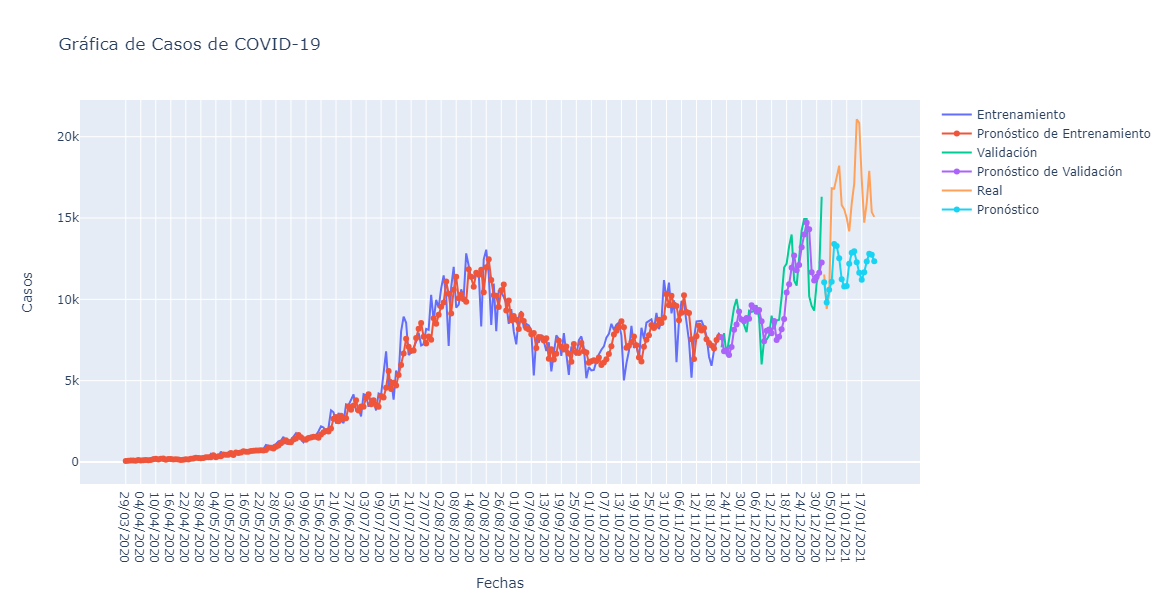

In [106]:
##Pruebas con otros L y r
#L = 43
#r = 6

print('The best performance is with L=')
print(L)
print('and r=')
print(r)
FTrain, FTest, Fcast, MTrain, MTest, MFcast = Forecast_SVD_Final(Fechas, Serie, N, L, n, r, HP)

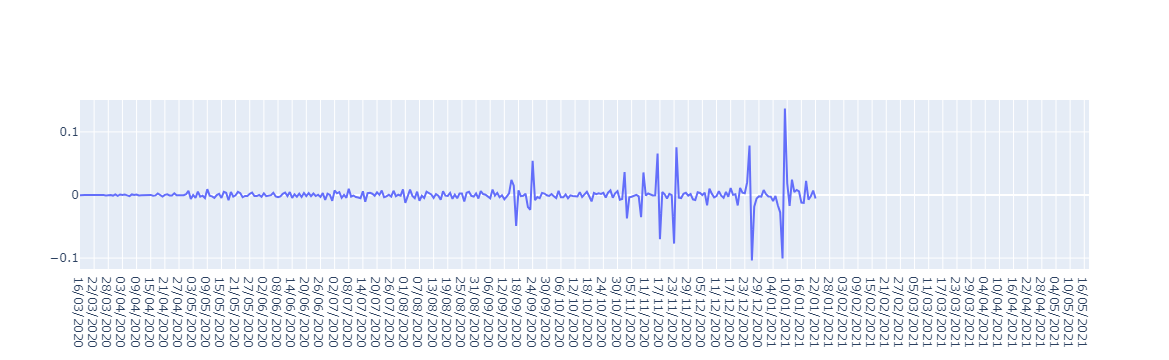

In [11]:
Real_Completa_df = pd.DataFrame(Serie[:N+HP])
Real_Completa    = Real_Completa_df.to_numpy()

RH             = series_to_supervised(data=Real_Completa_df.values.astype('float32').reshape(-1,1), n_in=L-1, n_out=1)
MRH            = np.array(RH)
RU, Rs, RVT    = svd(MRH)
SigmaRH        = np.zeros((MRH.shape[0], MRH.shape[1]))
SigmaRH[:MRH.shape[1], :MRH.shape[1]] = np.diag(Rs)
# Reconstruyendo con una reducción de valores singulares
NSigmaRH    = SigmaRH[:, :r]
NRVT        = RVT[:r, :]
NMRH        = RU.dot(NSigmaRH.dot(NRVT))
NRH         = NMRH[0,:-1]
NRH         = np.concatenate((NRH, NMRH[:,-1]), axis=0)
NRH         = np.array(NRH).reshape(-1,1)

Residuos_df = pd.DataFrame(NRH - Real_Completa) 
Residuos    = Residuos_df.to_numpy()

### Visualización
COVID_Time_Series_df['Residuos'] = pd.DataFrame(Residuos_df.values)

# Add traces
fig = go.Figure()

fig.add_trace(go.Scatter(x=COVID_Time_Series_df['FECHAS'], y=COVID_Time_Series_df['Residuos'], mode='lines',name='Serie Filtrada - Serie Real'))

fig.show()


In [13]:
### Análisis Residual

Dropr = []

maxLr = int(n/2)
Lr = np.arange(2, maxLr, 1, dtype=int)
print(Lr)

for lr in Lr:
    r = lr
    print('Lr=')
    print(lr)
    FTrainr, FTestr, Fcastr, MTrainr, MTestr, MFcastr = Forecast_SVD(Fechas, Residuos_df, N, lr, n, r, HP)
    Dropr = np.append(Dropr,MTestr)
    #Dropr = np.append(Dropr,MFcastr)
    
PerformanceLr = np.array(Dropr).reshape(-1,4)  
print(PerformanceLr)    
pos_bestLr = np.where(PerformanceLr == np.amin(PerformanceLr[:,3])) #Según RMSE
#pos_bestLr = np.where(PerformanceLr == np.amin(PerformanceLr[:,2])) #Según RMSEDD
#pos_bestLr = np.where(PerformanceLr == np.amax(PerformanceLr[:,1])) #Según MDA
#pos_bestLr = np.where(PerformanceLr == np.amin(PerformanceLr[:,0])) #Según MAPE
print(pos_bestLr)
print(pos_bestLr[0])
Lr = np.array(int(pos_bestLr[0]))+1  # Para MAPE y RMSE
#Lr = np.array(int(pos_bestLr[0][0]))+1 # Para MDA que se repiten
print(Lr)

Dropr = []

r = np.arange(1, Lr, 1, dtype=int)
print(r)

for rr in r:
    print('rr=')
    print(rr)
    FTrainr, FTestr, Fcastr, MTrainr, MTestr, MFcastr = Forecast_SVD(Fechas, Residuos_df, N, Lr, n, rr, HP)
    Dropr = np.append(Dropr,MTestr)
    #Dropr = np.append(Drop,MFcastr)
    
Performancerr = np.array(Dropr).reshape(-1,4)  
print(Performancerr)    
pos_bestrr = np.where(Performancerr == np.amin(Performancerr[:,3])) #Según RMSE
#pos_bestrr = np.where(Performancerr == np.amin(Performancerr[:,2])) #Según RMSEDD
#pos_bestrr = np.where(Performancerr == np.amax(Performancerr[:,1])) #Según MDA
#pos_bestrr = np.where(Performancerr == np.amin(Performancerr[:,0])) #Según MAPE
print(pos_bestrr)
rr = np.array(int(pos_bestrr[0]))+1   #Para MAPE y RMSE
#rr = np.array(int(pos_bestrr[0][0]))+1  #Para MDA que se repiten, urge mejorar MDA
print(rr)

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124]
Lr=
2
149.51919564369442
72.98387096774194
215.09792806214404
70.73170731707317
67512.53832693078
45.0
Lr=
3
168.99881166202525
72.06477732793523
306.8071560065849
80.48780487804879
219248.55104885547
55.00000000000001
Lr=
4
182.64117848630752
76.01626016260163
335.61647530500824
80.48780487804879
182804.3456519506
35.0
Lr=
5
192.02071778510484
72.6530612244898
299.353575272284
68.29268292682927
213074.2900888803
55.00000000000001
Lr=
6
192.7397553222443
75.81967213114754
521.289364136244
73.170

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

233.9753729025369
70.76271186440678
868.9779582672755
65.85365853658537
2842303.263257172
40.0
Lr=
15
235.2153949010062
70.63829787234043
859.0332504987275
65.85365853658537
3196732.8516480336
30.0
Lr=
16
238.64514764119727
67.09401709401709
991.1504846281268
68.29268292682927
3351644.5897101867
45.0
Lr=
17
237.59450885731897
68.24034334763948
991.8422101335566
68.29268292682927
3352912.498874499
40.0
Lr=
18
238.78440269708295
67.24137931034483
971.8775686856137
65.85365853658537
3843840.8501023487
30.0
Lr=
19
239.88991828087634
67.09956709956711
983.1474869736865
65.85365853658537
3821214.0186643493
25.0
Lr=
20
240.25820674225457
67.3913043478261
986.4713274270639
65.85365853658537
3819963.583161648
30.0
Lr=
21
240.80919363420173
69.43231441048034
969.9448302688577
65.85365853658537
3819833.525717219
30.0
Lr=
22
241.01917275160602
68.85964912280701
968.7694766870957
63.41463414634146
3755964.555560308
35.0
Lr=
23
241.50895604259998
67.84140969162996
968.7812960225777
65.85365853658537

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a scal

975.289228656812
68.29268292682927
3763925.0760417157
35.0
Lr=
25
231.28168405237986
67.11111111111111
955.6654693539143
65.85365853658537
3767126.9992819484
30.0
Lr=
26
232.83737117926304
67.41071428571429
957.7472670974738
65.85365853658537
3819440.378514933
40.0
Lr=
27
233.76757476532597
68.16143497757847
952.6937833378678
68.29268292682927
4242473.228986277
50.0
Lr=
28
233.92909429315853
68.46846846846847
951.9777748294787
68.29268292682927
4636771.525770597
35.0
Lr=
29
233.3060964115271
68.32579185520362
925.6379131896482
65.85365853658537
4623367.199558896
35.0
Lr=
30
231.08217131451386
70.45454545454545
918.3565346325687
63.41463414634146
4894905.9638562575
40.0
Lr=
31
227.72980976475608
68.0365296803653
901.4477853182327
63.41463414634146
5205753.201395372
40.0
Lr=
32
226.44951945509203
67.43119266055045
937.9316462291981
63.41463414634146
5704336.451927785
40.0
Lr=
33
220.46441224475024
71.42857142857143
897.6028011019955
60.97560975609756


C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:14: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

7502280.261491237
50.0
Lr=
34
219.0788015630687
70.83333333333334
914.5518760511103
60.97560975609756
7710287.785496582
40.0
Lr=
35
219.77341128739505
70.69767441860465
946.7740899836189
63.41463414634146
7554629.673283823
40.0
Lr=
36
222.0205816397284
70.56074766355141
928.3965446742103
65.85365853658537
7588497.972424214
35.0
Lr=
37
223.14448104819343
71.36150234741784
923.3481128796907
63.41463414634146
7701423.528886714
35.0
Lr=
38
221.4198735106073
72.16981132075472
925.9725668614387
63.41463414634146
7795850.162378094
35.0
Lr=
39
226.2619454335275
72.03791469194313
997.4441705847815
63.41463414634146
7814249.127895246
35.0
Lr=
40
221.34497544756752
70.47619047619048
1058.0604300802272
65.85365853658537
9279854.237899419
40.0
Lr=
41
223.9714144201194
69.85645933014354
1130.4827901851527
68.29268292682927


C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

10017932.422459949
35.0
Lr=
42
227.12448630914255
72.11538461538461
1174.7502003340528
60.97560975609756
10013382.563507035
35.0
Lr=
43
224.77434816378207
71.98067632850241
1139.9380509148145
58.536585365853654
9674786.552289756
40.0
Lr=
44
223.82396374258957
72.81553398058253
1139.0557940245424
58.536585365853654
9596130.897794582
40.0
Lr=
45
224.89336355003272
73.17073170731707
1123.744073389551
58.536585365853654
9594954.071120579
40.0
Lr=
46
226.19037084223626
73.0392156862745
1135.6791537004153
58.536585365853654
9690062.513148542
45.0
Lr=
47
227.19457048405843
74.8768472906404
1044.881170578563
65.85365853658537
10798616.778430488
45.0
Lr=
48
213.5129718081114
74.25742574257426
992.0598915891704
68.29268292682927
11162367.809539214
45.0
Lr=
49
213.12480625659626
74.6268656716418
997.4797010599032
68.29268292682927
11163488.98315245
45.0
Lr=
50
213.71056544048628
75.5
944.3864060208989
68.29268292682927


C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

11197550.07233501
45.0
Lr=
51
215.31969949020228
74.87437185929649
942.4067582442434
70.73170731707317
11176240.520905407
45.0
Lr=
52
213.5117541722071
74.74747474747475
930.9912506560055
70.73170731707317
11053598.96973014
50.0
Lr=
53
208.31860227539778
75.1269035532995
991.0657171898196
70.73170731707317
10996147.83961311
50.0
Lr=
54
210.63105269243505
73.9795918367347
719.7503107780744
70.73170731707317
13048100.115490302
40.0
Lr=
55
210.86891329209178
72.82051282051282
695.6434028396963
73.17073170731707
13150849.524515683
40.0
Lr=
56
210.88053917410372
73.19587628865979
704.1854162243116
70.73170731707317
13209150.267058741
40.0
Lr=
57
213.99148727326403
72.53886010362694
674.0478887900393
68.29268292682927
12898104.214006163
40.0
Lr=
58
215.65201148939062
72.39583333333334
690.7232303741524
65.85365853658537
13282521.46750849
40.0
Lr=
59


C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

215.0648907040413
72.77486910994764
699.0787841716489
63.41463414634146
13528976.449217865
40.0
Lr=
60
211.20608251506653
74.21052631578947
1028.1489515873338
60.97560975609756
13442223.521479638
40.0
Lr=
61
211.0683126227017
74.07407407407408
1143.6167985291836
58.536585365853654
14427507.620019916
40.0
Lr=
62
207.6777026056421
72.87234042553192
1132.117126127087
58.536585365853654
15734675.69831933
35.0
Lr=
63
202.58443059798168
74.33155080213903
1128.460174722412
58.536585365853654
15623945.603052968
40.0
Lr=
64
201.7943415708925
73.11827956989248
1106.2589419427934
53.65853658536586
15965334.14355836
35.0
Lr=
65
201.84157949546625
71.89189189189189
1130.2749196394436
56.09756097560976
15021651.619811779
45.0
Lr=
66
185.89506301170996
69.02173913043478
1305.6729504840866
56.09756097560976


C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

14956548.918695178
45.0
Lr=
67
187.2353685132854
70.49180327868852
1194.4316719732556
56.09756097560976
14773357.881247682
45.0
Lr=
68
187.71959071407056
70.32967032967034
1242.8216562517575
56.09756097560976
14953793.608015787
45.0
Lr=
69
191.70392779384773
70.71823204419888
1356.9834312864534
60.97560975609756
15188453.43498813
55.00000000000001
Lr=
70
185.6972272901187
72.22222222222221
1811.0701412099997
56.09756097560976
15132529.762500253
45.0
Lr=
71
194.24792481482848
73.74301675977654
1773.512489368204
58.536585365853654
15152072.565059705
45.0
Lr=
72
191.93028665575872
72.47191011235955
1824.1046617212883
58.536585365853654
15114512.819177458
45.0
Lr=
73
189.17388439235063
72.31638418079096
1618.4644489822344
60.97560975609756
15113635.967505015
45.0
Lr=
74


C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

189.011349742155
72.72727272727273
1516.575318191619
60.97560975609756
15718206.206990013
40.0
Lr=
75
188.2845532598844
72.57142857142857
1491.1957560266112
60.97560975609756
15052953.938670669
45.0
Lr=
76
186.1181173171451
71.26436781609196
1469.947783631169
60.97560975609756
15049652.048445968
45.0
Lr=
77
186.51082023776706
71.67630057803468
1469.4773196001947
60.97560975609756
14973312.325747944
45.0
Lr=
78
191.39562500600584
73.83720930232558
1373.8154739402419
65.85365853658537
14807037.41845903
50.0
Lr=
79
191.25594566068963
73.68421052631578
1386.532902843477
63.41463414634146
15184929.53847573
35.0
Lr=
80
188.33004250487497
71.76470588235294
1677.8414705731802
63.41463414634146
15632196.477687012
30.0
Lr=
81


C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

188.95100716535413
72.18934911242604
1574.049894921236
63.41463414634146
15323243.964546302
30.0
Lr=
82
188.01288828495393
72.02380952380952
1561.5701822213225
65.85365853658537
14865848.573517267
30.0
Lr=
83
188.88808502499919
71.25748502994011
1499.9719743850872
65.85365853658537
15070907.112918003
30.0
Lr=
84
189.90415678279453
71.08433734939759
1603.577836063344
63.41463414634146
15054600.651075976
30.0
Lr=
85
190.39139874530113
73.33333333333333
1583.3360440231627
60.97560975609756
14898148.949605595
30.0
Lr=
86
188.56191880017425
72.5609756097561
1707.3686951133852
60.97560975609756
14934841.468786653
35.0
Lr=
87
190.41755103231313
73.00613496932516
1668.9793708216316
56.09756097560976
14839136.013295898
35.0
Lr=
88


C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

191.23479363335207
73.4567901234568
1669.2031279544306
56.09756097560976
14685183.741422107
35.0
Lr=
89
191.73244793863316
72.67080745341616
1654.9044874844528
56.09756097560976
14289724.041590177
35.0
Lr=
90
190.13947915130126
71.875
1613.3835809738482
58.536585365853654
13974769.022792265
35.0
Lr=
91
190.0364646084244
72.32704402515722
1662.25914904224
63.41463414634146
14772892.96849559
35.0
Lr=
92
191.3629670626626
71.51898734177216
1727.702727146266
63.41463414634146
15722938.867568297
40.0
Lr=
93
196.41705239100096
72.61146496815286
1650.7366297845326
63.41463414634146
15037516.09183062
45.0
Lr=
94
193.74415343724354
75.0
1699.7422670940512
58.536585365853654
15025960.695816187
45.0
Lr=
95


C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

189.0444268463351
74.19354838709677
1672.2682689884375
56.09756097560976
15648241.785956187
45.0
Lr=
96
190.0159248377451
73.37662337662337
1676.739474582357
56.09756097560976
15649233.346688846
45.0
Lr=
97
191.0279466699548
75.81699346405229
2046.678544436627
58.536585365853654
16252119.393786825
45.0
Lr=
98
189.77173052544018
76.97368421052632
2187.901450660172
63.41463414634146
15908688.471320044
45.0
Lr=
99
182.09663331175025
74.17218543046357
2421.001832563484
60.97560975609756
16132399.04753561
45.0
Lr=
100
182.53637940864695
74.0
2575.2611347632605
58.536585365853654
15713566.803025827
45.0
Lr=
101
181.7584034115121
76.51006711409396
2819.028667431142
58.536585365853654


C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

19470803.69795848
40.0
Lr=
102
179.74544950365544
77.7027027027027
2850.264038746224
56.09756097560976
18739211.390201434
45.0
Lr=
103
182.3728230832338
76.19047619047619
3139.0316259631613
63.41463414634146
18118762.83965252
35.0
Lr=
104
181.77159925295953
75.34246575342466
2999.006816195051
60.97560975609756
21098004.958621792
40.0
Lr=
105
183.26033750351735
75.17241379310344
2984.4780334893667
60.97560975609756
21376683.533938177
35.0
Lr=
106
186.1195367834606
76.38888888888889
2710.897418274278
60.97560975609756
20891012.947393604
35.0
Lr=
107
189.43882968717023
74.82517482517483
2485.8434251304116
63.41463414634146


C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

20441611.186833955
35.0
Lr=
108
185.13021330242532
76.76056338028168
2942.783731590199
65.85365853658537
20692313.322259106
35.0
Lr=
109
181.14354658799815
76.59574468085107
2861.1243848489935
68.29268292682927
20371960.57821339
30.0
Lr=
110
176.55206228012167
77.14285714285715
2910.4945981695423
65.85365853658537
18970532.450596515
45.0
Lr=
111
170.08674414969036
76.97841726618705
3412.9240928283198
65.85365853658537
19738682.835062057
45.0
Lr=
112
168.8000694907035
78.26086956521739
3692.8189649615733
65.85365853658537
23646154.833501514
45.0
Lr=
113
159.5456207296696
81.02189781021897
4244.846416372551
63.41463414634146
24437233.58899563
45.0
Lr=
114


C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

151.37182583791707
80.88235294117648
4483.348929592983
63.41463414634146
25913641.491783075
45.0
Lr=
115
149.62607968204932
80.74074074074075
5129.332709734148
63.41463414634146
25807133.17919562
50.0
Lr=
116
148.3346483631324
80.59701492537313
5246.618679605432
63.41463414634146
25810686.986961417
40.0
Lr=
117
138.79988377314046
79.69924812030075
5563.067425106764
63.41463414634146
27218532.167045824
45.0
Lr=
118
115.87790078269624
81.81818181818183
5721.253935427109
65.85365853658537
32305197.85410636
40.0
Lr=
119
120.91470168233158
82.44274809160305
5732.355292561483
63.41463414634146
32520663.326887663
40.0
Lr=
120


C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

110.81981396820711
83.07692307692308
6306.317834196221
68.29268292682927
31662902.83894307
40.0
Lr=
121
104.9121127529561
86.82170542635659
6792.929766745663
65.85365853658537
31826510.94793567
40.0
Lr=
122
107.46178409640015
86.71875
6633.340465077987
68.29268292682927
32166584.563742235
45.0
Lr=
123
105.64725341937104
85.03937007874016
6369.393597445705
65.85365853658537
32146792.49328698
45.0
Lr=
124
95.20428799775893
89.68253968253968
6153.7333842822645
65.85365853658537
31066219.109220754
45.0
[[ 215.09792806   70.73170732  765.45909694  524.00054723]
 [ 306.80715601   80.48780488  702.70759433  508.54760173]
 [ 335.61647531   80.48780488  676.8846043   504.69783024]
 [ 299.35357527   68.29268293  678.48148299  507.64429328]
 [ 521.28936414   73.17073171  649.21751681  497.45011427]
 [1101.77174698   68.29268293  645.27676914  533.35316685]
 [ 963.35982803   70.73170732  687.05461938  505.08369556]
 [ 920.15358664   68.29268293  674.20395875  505.02074622]
 [ 898.70572307   68.292

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

1732874.6139650128
40.0
rr=
3
235.47248759723902
65.29680365296804
1333.980420954807
65.85365853658537
1694027.5418056156
45.0
rr=
4
233.86547569413432
66.21004566210046
1203.1503976115032
68.29268292682927
2085197.5539603606
35.0
rr=
5
236.62192470097563
62.55707762557078
737.3639773110273
65.85365853658537
2172241.9428751203
40.0
rr=
6
238.39619348909844
64.38356164383562
737.7122430887098
65.85365853658537
2225382.4395331494
35.0
rr=
7
244.6784029182555
61.18721461187214
754.0281900766553
68.29268292682927
2274457.184056642
30.0
rr=
8
246.132025179913
63.013698630136986
612.3345643859498
70.73170731707317
2394620.8600363606
50.0
rr=
9
249.77980133622785
63.4703196347032
657.5139542601911
70.73170731707317
2336292.6190023352
50.0
rr=
10
238.83613539934794
67.12328767123287
755.0249575757737
70.73170731707317
3457350.2308905907
50.0
rr=
11
238.47172215014754
67.57990867579909
752.6428610932339
70.73170731707317
3525072.3962544734
55.00000000000001
rr=
12
241.11683072226455
63.92694063

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a scal

683.7249078719152
70.73170731707317
2856043.6776417005
30.0
rr=
15
240.62770439442932
63.4703196347032
937.6573697599822
60.97560975609756
2936180.595118678
30.0
rr=
16
239.9459650041822
63.013698630136986
1067.2657496802333
58.536585365853654
2407441.722907413
35.0
rr=
17
242.63280369291738
62.10045662100456
1086.6778120170607
56.09756097560976
2444506.2499494078
35.0
rr=
18
238.22082065404743
64.84018264840182
1093.4975869881898
60.97560975609756
3248114.5434937393
35.0
rr=
19
238.0179379830133
65.29680365296804
1085.325471870613
63.41463414634146
3045330.6684232526
40.0
rr=
20
238.07920254477526
65.29680365296804
1084.9479150745221
63.41463414634146
2890531.326915906
30.0
rr=
21
239.36742937429938
66.66666666666666
1084.1202828048852
63.41463414634146
2916365.7879996873
30.0
rr=
22
240.70078877972068
66.66666666666666
1098.461139528243
63.41463414634146
4094720.5777833015
40.0
rr=
23
234.86930655695068
66.66666666666666
1112.8104705223266
63.41463414634146
3850393.2005256386
40.0
rr

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

The best performance is with Lr=
31
and rr=
30
Mape de Entrenamiento
227.72979622103952
MDA de Entrenamiento
68.0365296803653
RMSE de Entrenamiento
149.615545911098
Desviación de la Dirección de Entrenamiento en RMSE
212.15189604298826
Mape de Validación
901.4476752394721
MDA de Validación
63.41463414634146
RMES de Validación
503.1627487234567
Desviación de la Dirección de Validación en RMSE
679.6368651859578
MAPE del Pronóstico
288.08803270878803
MDA del Pronóstico
40.0
RMSE del Pronóstico
976.0504552294144 952674.4911535471
Desviación de la Dirección del Pronóstico en RMSE
1596.5517815280955


C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:25: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:14: DeprecationWarning:

Conversion of an array with ndim > 0 to a scala

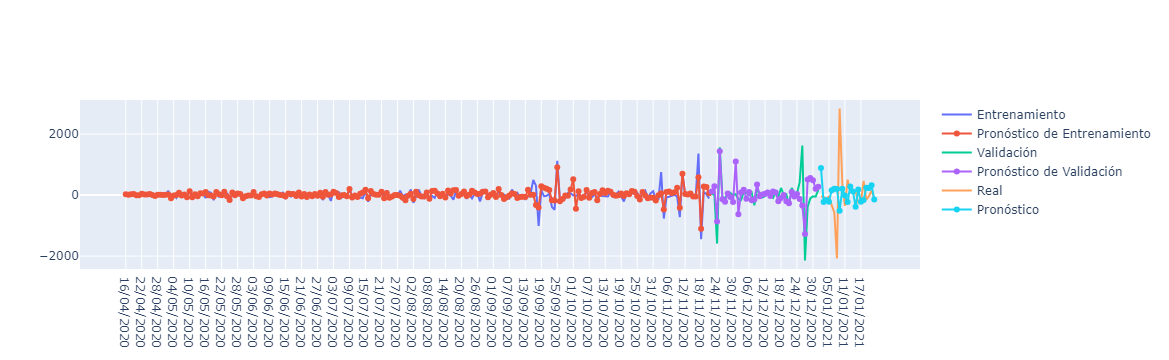

In [14]:
print('The best performance is with Lr=')
print(Lr)
print('and rr=')
print(rr)
##Pruebas con otros L y r
#Lr = 20
#rr = 15

FRTrain, FRTest, FRcast, MRTrain, MRTest, MRFcast = Forecast_SVD_Final(Fechas, Residuos_df, N, Lr, n, rr, HP)


Mape del Pronóstico Final
30.47821591666996
Promedio de la Presición de la Dirección
65.0
Raiz Cuadrática del Error Cuadrático Medio
6166.733651795133


C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:24: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\chris\AppData\Local\Temp\ipykernel_9752\420372440.py:14: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



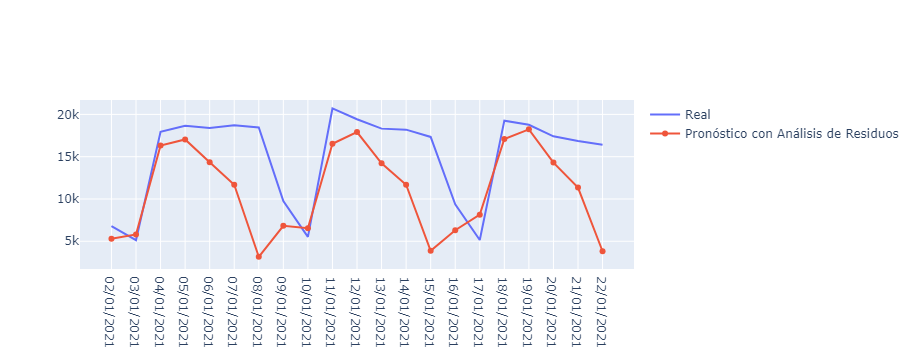

In [15]:
Pronos  = Fcast -  FRcast
real_df = pd.DataFrame(Serie[N:N+HP])
real    = np.array(real_df).reshape(-1,1)
Real    = sc.inverse_transform(real)
print('Mape del Pronóstico Final')
Mape_F, DifF = MAPE(Real, Pronos)

print('Promedio de la Presición de la Dirección')
MDAF = mda(Real, Pronos)

print('Raiz Cuadrática del Error Cuadrático Medio')
rmseF, mseF  = RMSE(Real, Pronos)
print(rmseF)

Pronos_df = pd.DataFrame(Pronos)

#
FechasF_df  = pd.DataFrame(Fechas[N:N+HP])
Fcast_F_df                   = pd.DataFrame(Real, columns=['Real'])
Fcast_F_df['Fechas_Fcast']   = pd.DataFrame(FechasF_df.values)
Fcast_F_df['Fcast+ARes']     = pd.DataFrame(Pronos)
#

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=Fcast_F_df['Fechas_Fcast'], y=Fcast_F_df['Real'], 
                    mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=Fcast_F_df['Fechas_Fcast'], y=Fcast_F_df['Fcast+ARes'], 
                    mode='lines+markers', name='Pronóstico con Análisis de Residuos'))

fig.show()